# Bayesian Regularization

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import cvxpy as cp

Consider the following simulated dataset (this data was used in Lecture 11). 

In [3]:
def smoothfun(x):
    ans = np.sin(15 * x) + 3 * np.exp(-(x ** 2)/2) + 0.5 * ((x - 0.5) ** 2) + 5 * np.log(x + 0.1) + 7
    return ans

n = 1000
xx = np.linspace(0, 1, n)
truth = np.array([smoothfun(x) for x in xx])

sig = 2
rng = np.random.default_rng(seed = 32)
errorsamples = rng.normal(loc=0, scale = sig, size = n)
y = truth + errorsamples

Here is a plot of the dataset along with the true trend function. 

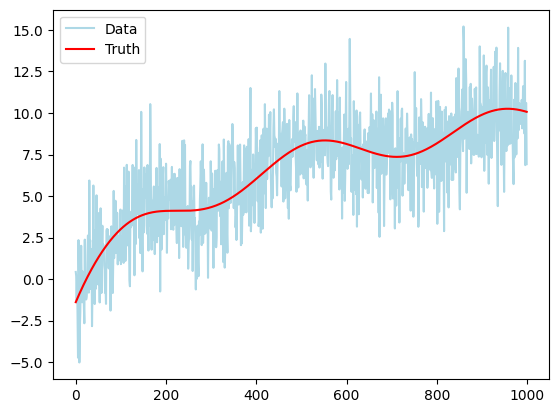

In [4]:
plt.plot(y, label = 'Data', color = 'lightblue')
plt.plot(truth, label = 'Truth', color = 'red')
plt.legend()
plt.show()

We work with the following prior:
\begin{align*}
   \beta_0, \beta_1 \overset{\text{i.i.d}}{\sim} N(0, C) ~~~ \beta_2, \dots, \beta_{n-1} \overset{\text{i.i.d}}{\sim} N(0, \gamma^2 \sigma^2)
\end{align*}
We treat $\gamma$ and $\sigma$ also as unknown parameters and assign the prior: 
\begin{align*}
    \log \gamma, \log \sigma \overset{\text{i.i.d}}{\sim} \text{unif}(-C, C). 
\end{align*}
This prior was introduced in Lecture 13. It is slightly different from the prior used in Lecture 12 which assumed that $\log \tau, \log \sigma \overset{\text{i.i.d}}{\sim} \text{unif}(-C, C)$. The advantage with this prior is that marginalization of the posterior with respect to $\beta$ and $\sigma$ can both be done in closed form. So we would only need a grid for evaluating the posterior for $\gamma$. In contrast, for the previous prior, we needed a grid for both $\sigma$ and $\gamma$. 

The posterior of $\gamma, \sigma, \beta$ can be described as follows. 


The posterior of $\beta$ conditional on $\sigma$ and $\gamma$ is given by: 
\begin{align*}
   \beta \mid \text{data}, \sigma, \gamma \sim N \left(\left(\frac{X^T
                          X}{\sigma^2} + Q^{-1}  \right)^{-1} \frac{X^T y}{\sigma^2},  \left(\frac{X^T X}{\sigma^2} + Q^{-1} \right)^{-1}\right). 
\end{align*}
where $Q$ is the diagonal matrix with diagonal entries $C, C, \gamma^2\sigma^2, \dots, \gamma^2\sigma^2$. This is the same as before. We shall again use the approximation $Q^{-1} \approx J/\tau^2 = J/(\gamma \sigma)^2$. 

We next describe the posterior of $\gamma$ and $\sigma$. Unlike the case of the previous prior, the posterior of $\sigma$ conditional on $\gamma$ can be described in closed form as: 

 \begin{equation*}
   \frac{1}{\sigma^2} \mid \text{data}, \gamma \sim \text{Gamma} \left(\frac{n}{2} - 1, \frac{y^T y - y^T X (X^T X + \gamma^{-2} J)^{-1} X^T y}{2} \right) 
 \end{equation*}
 Finally the posterior of $\gamma$ is given by: 

 \begin{align*}
   \gamma \mid \text{data} \sim \gamma^{-n+1} \sqrt{\det (X^T X + \gamma^{-2} J)^{-1}} \left(\frac{1}{y^T y - y^T X (X^T X + \gamma^{-2} J)^{-1} X^T y} \right)^{(n/2) - 1}
 \end{align*}

 We can compute this posterior on a grid of $\gamma$ values.

In [5]:
n = len(y)
x = np.arange(1, n+1)
X = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float)) * (x-c)
    X = np.column_stack([X, xc])

print(X)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 997. 996. ...   1.   0.  -0.]
 [  1. 998. 997. ...   2.   1.   0.]
 [  1. 999. 998. ...   3.   2.   1.]]


To select the grid range for $\gamma$, we can use the following method. For a fixed $\gamma$, note that the ridge regularized estimate of $\beta$ with tuning parameter $\lambda = 1/\gamma^2$ is given by $(X^T X + \lambda J)^{-1}X^Ty$. We choose $\lambda_{\min}$ to be such that the fitted values corresponding to the ridge estimator look like the data (overfitting) and $\lambda_{\max}$ to be such that the fitted values are close to being a line. The range for $\gamma$ is then $[1/\sqrt{\lambda_{\max}}, 1/\sqrt{\lambda_{\min}}]$.  

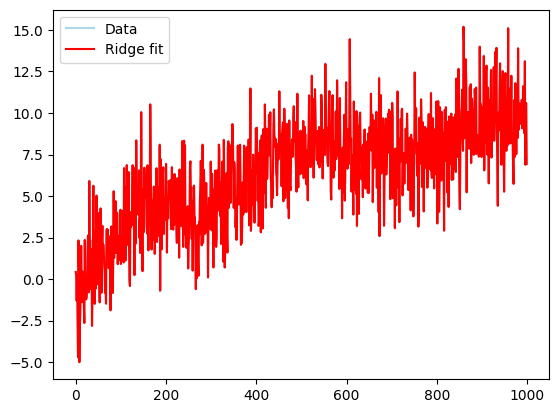

In [ ]:
lambda_ridge = 1e-2
ridge_beta = np.linalg.inv(X.T @ X + lambda_ridge * np.eye(n)) @ X.T @ y
ridge_fitted = X @ ridge_beta

plt.plot(y, label = 'Data', color = 'lightblue')
plt.plot(ridge_fitted, label = 'Ridge fit', color = 'red')
plt.legend()
plt.show()

#this plot suggests:
lambda_min = 1e-2

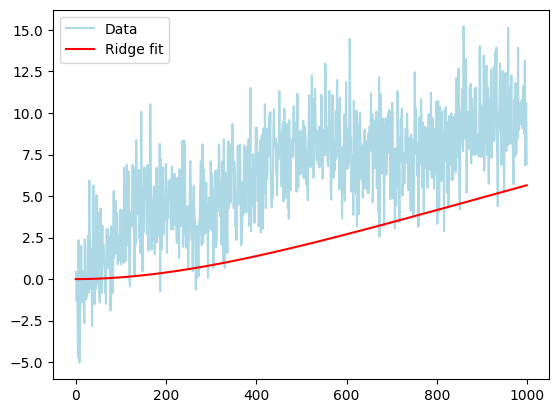

In [ ]:
lambda_ridge = 1e9
ridge_beta = np.linalg.inv(X.T @ X + lambda_ridge * np.eye(n)) @ X.T @ y
ridge_fitted = X @ ridge_beta

plt.plot(y, label = 'Data', color = 'lightblue')
plt.plot(ridge_fitted, label = 'Ridge fit', color = 'red')
plt.legend()
plt.show()

#this plot suggests:
lambda_max = 1e9

In [ ]:
gamma_min = 1 / np.sqrt(lambda_max)
gamma_max = 1 / np.sqrt(lambda_min)
print(gamma_min, gamma_max)

3.1622776601683795e-05 10.0


We take a grid of $\gamma$ in the range given by the minimum and maximum values above. The grid will be chosen uniformly over the log-scale. 

In [ ]:
gamma_gr = np.logspace(np.log10(gamma_min), np.log10(gamma_max), 100)
logpost_gamma = np.zeros(len(gamma_gr))

for i in range(len(gamma_gr)):
    gamma = gamma_gr[i]

    J_by_gammasq = np.diag(np.concatenate([[0, 0], np.repeat(gamma**(-2), n-2)])) 
    Mat = X.T @ X + J_by_gammasq
    Matinv = np.linalg.inv(Mat)

    sgn, logcovdet = np.linalg.slogdet(Matinv)

    logpost_gamma[i] = (
        (-n+1) * np.log(gamma) + 0.5 * logcovdet 
        - (n/2 - 1) * np.log(y.T @ y - y.T @ X @ Matinv @ X.T @ y)
    )

    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90


In [ ]:
post_gamma  = np.exp(logpost_gamma - np.max(logpost_gamma))
post_gamma = post_gamma / np.sum(post_gamma)

For a point estimate of $\gamma$, we can compute the posterior mean as follows. 

In [ ]:
postmean_gamma = np.sum(gamma_gr * post_gamma)
print(postmean_gamma)
print(1 / (postmean_gamma ** 2))

0.001010381757700345
979555.408826349


Posterior samples from $\gamma$ can be generated as follows. 

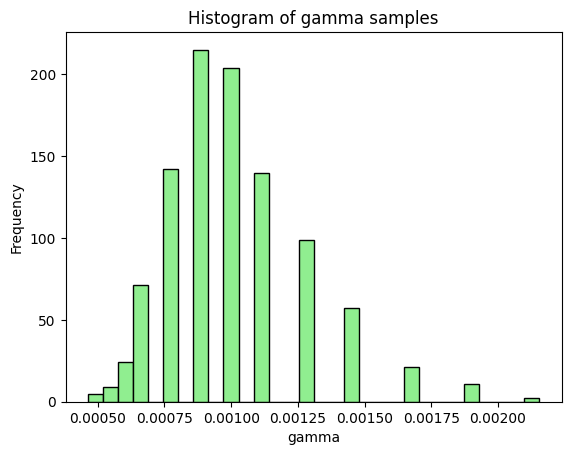

In [ ]:
N = 1000
gamma_samples = np.random.choice(gamma_gr, size=N, p=post_gamma, replace=True)

plt.hist(gamma_samples, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histogram of gamma samples')
plt.xlabel('gamma')
plt.ylabel('Frequency')
plt.show()

Here is the code for generating the samples from the other parameters $\sigma$ and $\beta$. 

In [ ]:
N = 100
sig_samples = np.array(np.zeros(N))
betahats = np.zeros((n, N))
muhats = np.zeros((n, N))

for i in range(N):
    gamma = gamma_samples[i]
    J_by_gammasq = np.diag(np.concatenate([[0, 0], np.repeat(gamma**(-2), n-2)])) 
    Mat = X.T @ X + J_by_gammasq
    Matinv = np.linalg.inv(Mat)

    gamma_dist_lambda_parameter = (y.T @ y - y.T @ X @ Matinv @ X.T @ y)/2
    gamma_dist_alpha_parameter = n/2 - 1

    sig = np.sqrt(1 / np.random.gamma(gamma_dist_alpha_parameter, 1/gamma_dist_lambda_parameter))
    sig_samples[i] = sig

    XTX = np.dot(X.T, X)
    TempMat = np.linalg.inv((J_by_gammasq/(sig ** 2)) + (XTX/(sig ** 2)))
    XTy = np.dot(X.T, y)
    #generate betahat from the normal distribution with mean: 
    norm_mean = np.dot(TempMat, XTy/(sig ** 2)) 
    #and covariance matrix: 
    norm_cov = TempMat  

    betahat = np.random.multivariate_normal(norm_mean, norm_cov)
    muhat = np.dot(X, betahat)

    betahats[:,i] = betahat
    muhats[:,i] = muhat
    
    if i % 10 == 0:
        print(i)
    

0
10
20
30
40
50
60
70
80
90


Below we compute and plot the posterior means for $\beta$ and $X \beta$. 

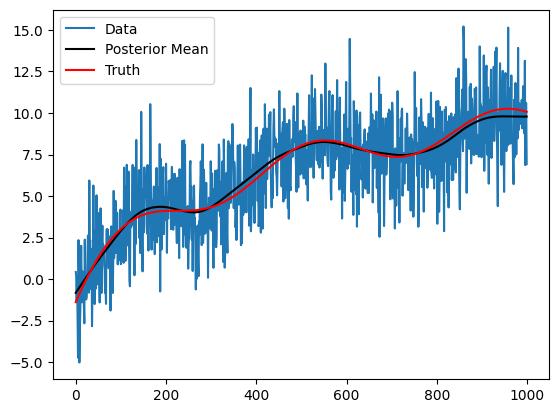

In [ ]:
beta_est = np.mean(betahats, axis = 1)
mu_est = np.mean(muhats, axis = 1) #these are the fitted values

plt.plot(y, label = 'Data')
plt.plot(mu_est, color = 'black', label = 'Posterior Mean')
plt.plot(truth, color = 'red', label = 'Truth')
plt.legend()
plt.show()

Below we plot the individual posterior samples for $X\beta$. These can be used for uncertainty quantification. 

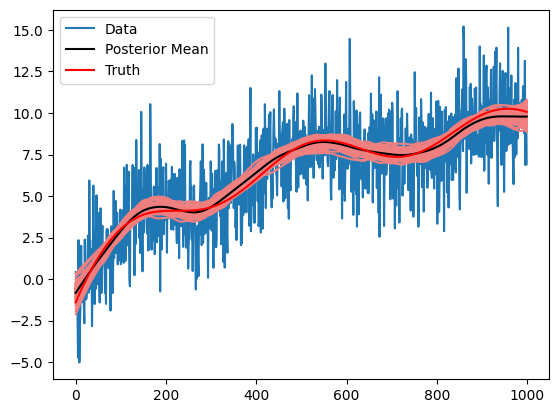

In [ ]:
#Plotting all the posterior fitted values
plt.plot(y, label = 'Data')
for i in range(N):
    plt.plot(muhats[:,i], color = 'lightcoral')
plt.plot(mu_est, color = 'black', label = 'Posterior Mean')
plt.plot(truth, color = 'red', label = 'Truth')
plt.legend()
plt.show()

The true smooth function (which generated the data) is inside the bands given by the individual posterior samples of $X\beta$. 

Here is the histogram of the $\sigma$ values. 

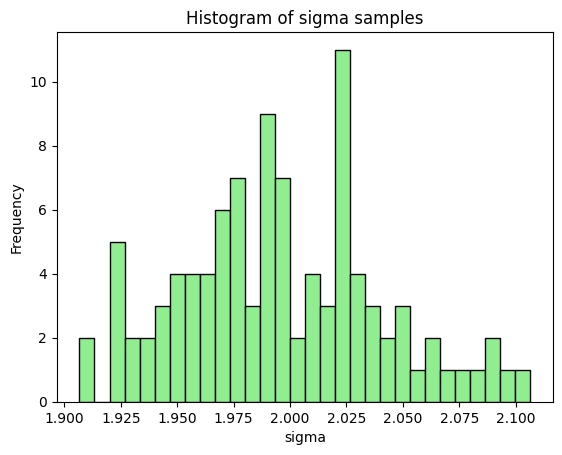

In [15]:
plt.hist(sig_samples, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histogram of sigma samples')
plt.xlabel('sigma')
plt.ylabel('Frequency')
plt.show()

Note that the true $\sigma$ which generated the data is 2. 

## One More Example

We now consider one more example where the data is generated from a true trend function that is piecewise linear. In this case, this method works still well but struggles to find the sharp change of slope points. Instead, it ends up smoothing those kink points.

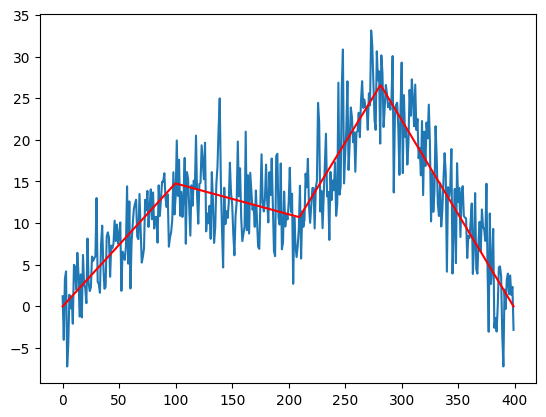

In [ ]:
def piece_linear(x):
    ans = np.zeros_like(x, dtype=float)
    
    # First segment: 0 <= x <= 0.25
    mask1 = (x >= 0) & (x <= 0.25)
    ans[mask1] = (14.77491 / 0.25) * x[mask1]
    
    # Second segment: 0.25 < x <= 0.525
    mask2 = (x > 0.25) & (x <= 0.525)
    ans[mask2] = (10.71181 + ((10.71181 - 14.77491) / (0.525 - 0.25)) * (x[mask2] - 0.525))
    
    # Third segment: 0.525 < x <= 0.705
    mask3 = (x > 0.525) & (x <= 0.705)
    ans[mask3] = (26.59484 + ((26.59584 - 10.71181) / (0.705 - 0.525)) * (x[mask3] - 0.705))
    
    # Fourth segment: 0.705 < x <= 1
    mask4 = (x > 0.705) & (x <= 1)
    ans[mask4] = ((0 - 26.59584) / (1 - 0.705)) * (x[mask4] - 1)
    
    return ans

n = 400
xx = np.linspace(0, 1, 400)
truth = piece_linear(xx)

sig = 4
rng = np.random.default_rng(seed = 42)
errorsamples = rng.normal(loc=0, scale = sig, size = n)
y = truth + errorsamples

plt.plot(y, label = 'Data')
plt.plot(truth, label = 'Truth', color = 'red')
plt.show()

In [ ]:
n = len(y)
x = np.arange(1, n+1)
X = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float)) * (x-c)
    X = np.column_stack([X, xc])

print(X)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 397. 396. ...   1.   0.  -0.]
 [  1. 398. 397. ...   2.   1.   0.]
 [  1. 399. 398. ...   3.   2.   1.]]


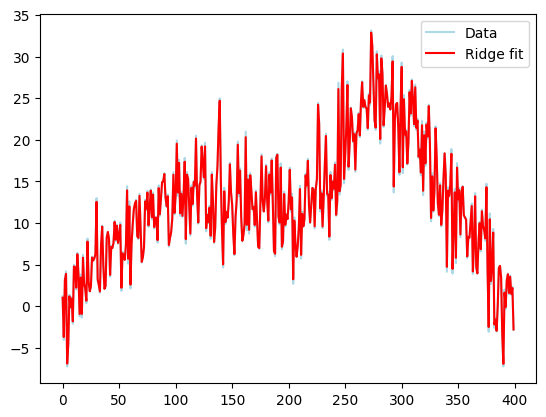

In [ ]:
lambda_ridge = 1e-2
ridge_beta = np.linalg.inv(X.T @ X + lambda_ridge * np.eye(n)) @ X.T @ y
ridge_fitted = X @ ridge_beta

plt.plot(y, label = 'Data', color = 'lightblue')
plt.plot(ridge_fitted, label = 'Ridge fit', color = 'red')
plt.legend()
plt.show()

#this plot suggests:
lambda_min = 1e-2

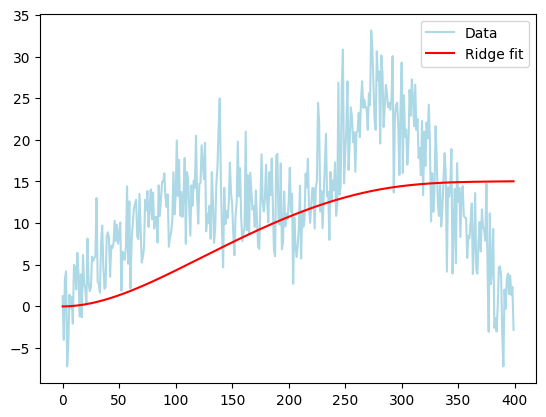

In [ ]:
lambda_ridge = 1e8
ridge_beta = np.linalg.inv(X.T @ X + lambda_ridge * np.eye(n)) @ X.T @ y
ridge_fitted = X @ ridge_beta

plt.plot(y, label = 'Data', color = 'lightblue')
plt.plot(ridge_fitted, label = 'Ridge fit', color = 'red')
plt.legend()
plt.show()

#this plot suggests:
lambda_max = 1e8

In [ ]:
gamma_min = 1 / np.sqrt(lambda_max)
gamma_max = 1 / np.sqrt(lambda_min)
print(gamma_min, gamma_max)

0.0001 10.0


In [ ]:
gamma_gr = np.logspace(np.log10(gamma_min), np.log10(gamma_max), 1000)
logpost_gamma = np.zeros(len(gamma_gr))

for i in range(len(gamma_gr)):
    gamma = gamma_gr[i]
    J_by_gammasq = np.diag(np.concatenate([[0, 0], np.repeat(gamma**(-2), n-2)])) 
    Mat =  X.T @ X + J_by_gammasq
    Matinv = np.linalg.inv(Mat)

    sgn, logcovdet = np.linalg.slogdet(Matinv)
    
    logpost_gamma[i] = (
        (-n+1) * np.log(gamma) + 0.5 * logcovdet 
        - (n/2 - 1) * np.log(y.T @ y - y.T @ X @ Matinv @ X.T @ y)
    )

    if i % 10 == 0:
        print(i)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [ ]:
post_gamma = np.exp(logpost_gamma - np.max(logpost_gamma))
post_gamma = post_gamma / np.sum(post_gamma)

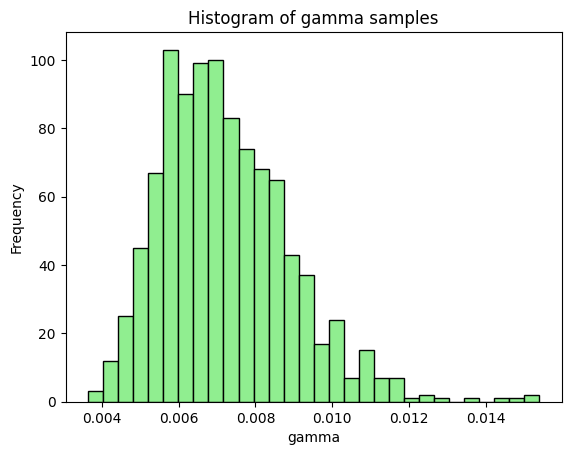

In [23]:
N = 1000
gamma_samples = np.random.choice(gamma_gr, size=N, p=post_gamma, replace=True)
plt.hist(gamma_samples, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histogram of gamma samples')
plt.xlabel('gamma')
plt.ylabel('Frequency')
plt.show()

In [ ]:
N = 100
sig_samples = np.array(np.zeros(N))
betahats = np.zeros((n, N))
muhats = np.zeros((n, N))

for i in range(N):
    gamma = gamma_samples[i]
    J_by_gammasq = np.diag(np.concatenate([[0, 0], np.repeat(gamma**(-2), n-2)])) 
    Mat = X.T @ X + J_by_gammasq
    Matinv = np.linalg.inv(Mat)

    gamma_dist_lambda_parameter = (y.T @ y - y.T @ X @ Matinv @ X.T @ y)/2
    gamma_dist_alpha_parameter = n/2 - 1

    sig = np.sqrt(1/np.random.gamma(gamma_dist_alpha_parameter, 1/gamma_dist_lambda_parameter))
    sig_samples[i] = sig

    XTX = np.dot(X.T, X)
    TempMat = np.linalg.inv((J_by_gammasq/(sig ** 2)) + (XTX/(sig ** 2)))
    XTy = np.dot(X.T, y)
    #generate betahat from the normal distribution with mean: 
    norm_mean = np.dot(TempMat, XTy/(sig ** 2)) 
    #and covariance matrix: 
    norm_cov = TempMat

    betahat = np.random.multivariate_normal(norm_mean, norm_cov)
    muhat = np.dot(X, betahat)

    betahats[:,i] = betahat
    muhats[:,i] = muhat

    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90


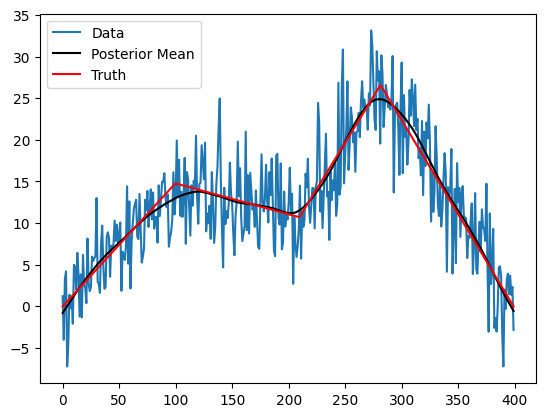

In [ ]:
beta_est = np.mean(betahats, axis = 1)
mu_est = np.mean(muhats, axis = 1) # these are the fitted values

plt.plot(y, label = 'Data')
plt.plot(mu_est, color = 'black', label = 'Posterior Mean')
plt.plot(truth, color = 'red', label = 'Truth')
plt.legend()
plt.show()

See how the sharp kink points are smoothed in the estimate given by the Bayesian method. 

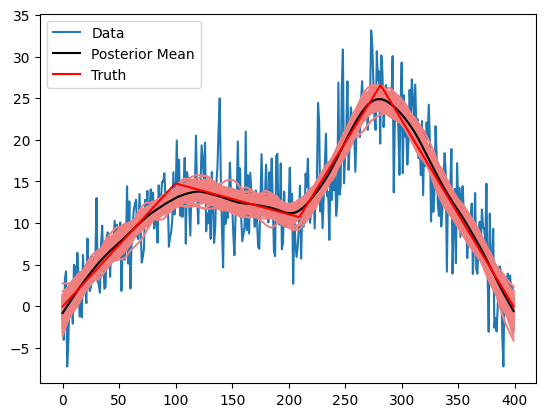

In [ ]:
# Plotting all the posterior fitted values
plt.plot(y, label = 'Data')
for i in range(N):
    plt.plot(muhats[:,i], color = 'lightcoral')
plt.plot(mu_est, color = 'black', label = 'Posterior Mean')
plt.plot(truth, color = 'red', label = 'Truth')
plt.legend()
plt.show()

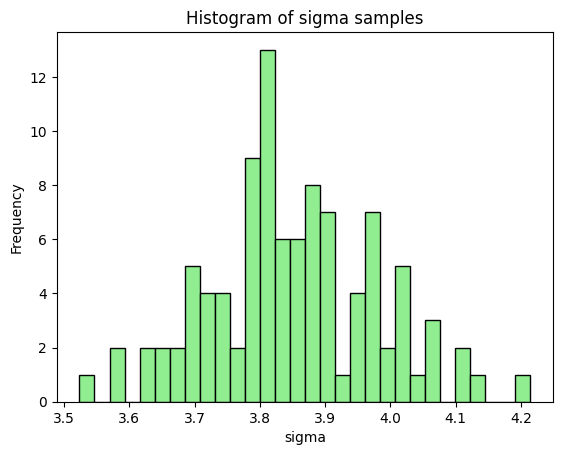

In [27]:
plt.hist(sig_samples, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histogram of sigma samples')
plt.xlabel('sigma')
plt.ylabel('Frequency')
plt.show()